In [28]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch, torch.nn as nn
from tqdm import tqdm
from skimage.metrics import peak_signal_noise_ratio as compare_psnr


%matplotlib inline

In [29]:
# setup
torch.manual_seed(0)
plt.rcParams['toolbar'] = 'none'
plt.ion() # interactive mode
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


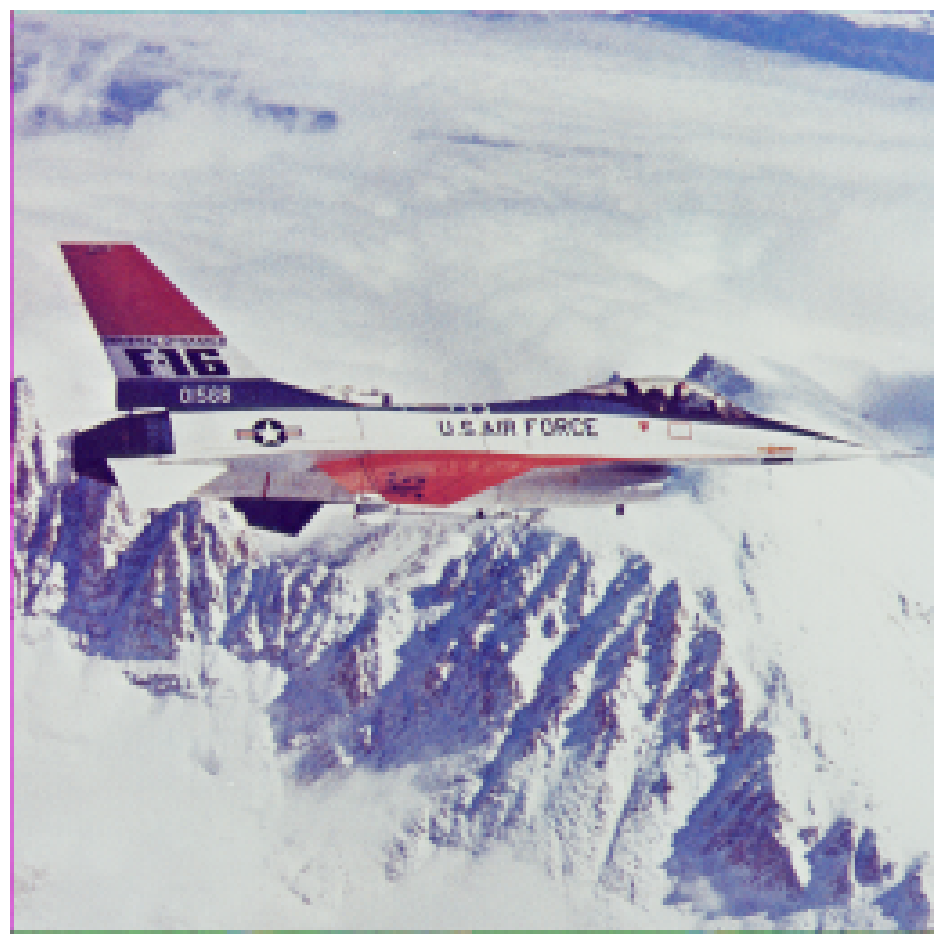

In [30]:
nxd = 256  # pixels in x dimension
img = cv2.imread('/kaggle/input/images/F16_GT.png')
img = cv2.resize(src=img, dsize=(nxd, nxd), interpolation=cv2.INTER_CUBIC)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

fig1, axis1 = plt.subplots(1, 1, figsize=(20,12))
axis1.imshow(img)
axis1.set_axis_off()

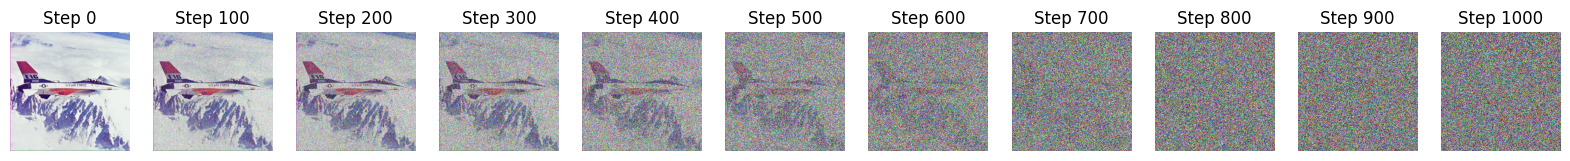

In [65]:
def forward_diffusion(x0, num_steps, beta_start, beta_end):
    betas = np.linspace(beta_start, beta_end, num_steps)
    alphas = 1 - betas
    alphas_cumprod = np.cumprod(alphas)
    
    x_t = []
    x_t.append(x0)
    for t in range(1, num_steps + 1):
        noise = np.random.randint(x0.min(), x0.max(), size=x0.shape)
        alpha_t = alphas_cumprod[t-1]
        x_t_prev = x_t[-1]
        x_t_current = np.sqrt(alpha_t) * x0 + np.sqrt(1 - alpha_t) * noise
        x_t.append(x_t_current)
    
    output = np.array(x_t)[0:1001:100]
    for i in range(len(output)):
        img_array = output[i]
        img_array = (img_array - img_array.min()) / (img_array.max() - img_array.min())  # Normalize to [0, 1]
        output[i] = img_array
    
    return output, alphas_cumprod

def plot_images(x_t, indices):
    num_images = len(indices)
    fig, axes = plt.subplots(1, num_images, figsize=(20, 12))
    for ax, idx in zip(axes, indices):
        ax.imshow(x_t[idx])
        ax.set_title(f'Step {idx*100}')
        ax.axis('off')
    plt.show()

x0 = img
num_steps = 1000
beta_start = 0.0001
beta_end = 0.02

x_t, alphas_cumprod = forward_diffusion(x0, num_steps, beta_start, beta_end)

# Plot specific time steps
plot_images(x_t, indices=[i for i in range(0, 11)])

In [66]:
# setup cnn class
class CNN(nn.Module):
    def __init__(self, n_layer, n_channel, kernel_size):
        super(CNN, self).__init__()
        pd = int(kernel_size/2)
        layers = [nn.Conv2d(3, n_channel, kernel_size, padding=pd), nn.PReLU(),]
        for _ in range(n_layer):
            layers.append(nn.Conv2d(n_channel, n_channel, kernel_size, padding=pd))
            layers.append(nn.PReLU())
        layers.append(nn.Conv2d(n_channel, 3, kernel_size, padding=pd))
        layers.append(nn.PReLU())
        
        self.deep_net = nn.Sequential(*layers)
        
    def forward(self, x):
        x = x.permute(2, 0, 1)
        return torch.squeeze(self.deep_net(x.unsqueeze(0)))
    
cnn = CNN(8, 64, 3).to(device)

Text(0.5, 1.0, 'z image 256 x 256')

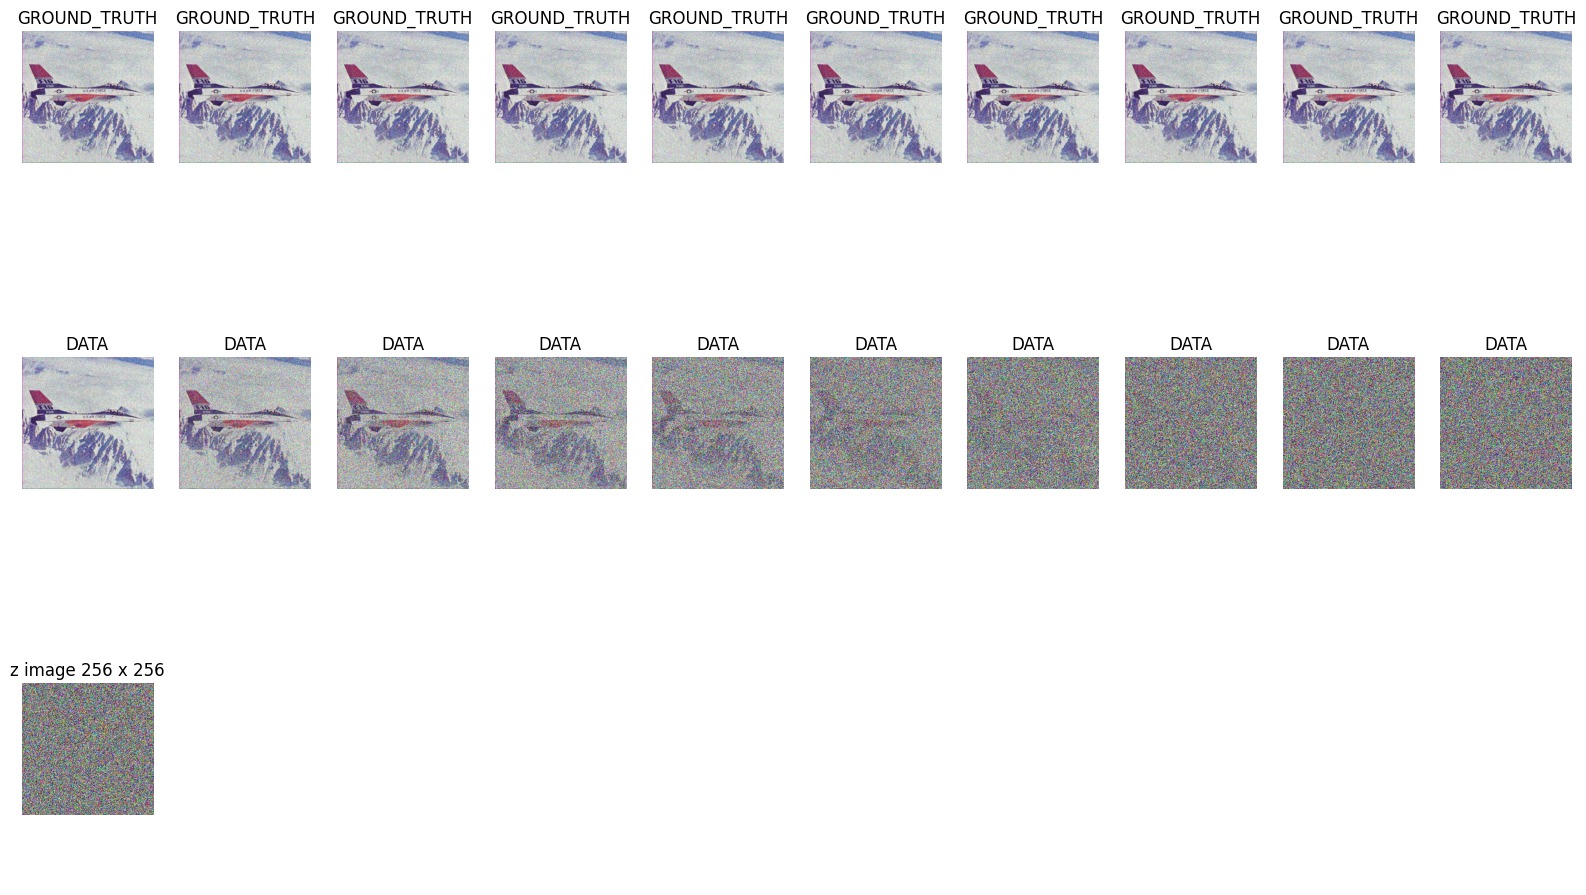

In [67]:
# input image is pure noise
input_image = torch.rand(nxd, nxd, 3).to(device)  

def torch_to_numpy(torch_array):
    return np.squeeze(torch_array.detach().cpu().numpy())
def numpy_to_torch(numpy_array):
    return torch.from_numpy(numpy_array).float()

true_object_torch = numpy_to_torch(img).to(device)
measured_data = torch.poisson(true_object_torch)

fig2, axis2 = plt.subplots(3, len(x_t)-1, figsize=(20,12))
for i in range(10):
    axis2[0,i].imshow(x_t[1])
    axis2[0,i].set_title('GROUND_TRUTH')
    axis2[0,i].set_axis_off()
    axis2[1,i].imshow(x_t[i+1])
    axis2[1,i].set_title('DATA')
    axis2[1,i].set_axis_off()
    axis2[2,i].set_axis_off()

axis2[2,0].imshow(torch_to_numpy(input_image))
axis2[2,0].set_title('z image %d x %d' %(nxd, nxd))


In [68]:
for i in range(10):
    print(x_t[i].min(), x_t[i].max())

0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0


In [69]:
# initialize training things
optimiser = torch.optim.Adam(cnn.parameters(), lr=1e-4)
train_loss = list()
psnr_list = list()
best_psnr = 10e9

output_images = []
output_psnr = []
output_ep = []

In [76]:
ind = -1
mse_fn = nn.MSELoss().to(device)

# training process
for ind in range(-1, -10, -1):
    for ep in tqdm(range(1000)):
        optimiser.zero_grad()
        output_image = cnn(input_image)
        output_image = output_image.squeeze(0).permute(1, 2, 0)
#         print(output_image.min(), output_image.max())
        loss = mse_fn(numpy_to_torch(x_t[ind]).to(device), output_image)

        train_loss.append(loss.item())
        loss.backward() # find gradients
        optimiser.step() # does the update

        psnr = compare_psnr(torch_to_numpy(output_image), x_t[1])
        psnr_list.append(psnr.item())
    
    print(loss.item())

#         if(ep % 100 == 0):
    output_images.append(output_image)
    output_psnr.append(psnr)
    output_ep.append(ep)
    print(ind)
#     if(psnr < best_psnr):
#         best_recon = output_image
#         best_psnr = psnr
#         best_ep = ep
#         axis1[1,2].cla()
#         axis1[1,2].imshow(torch_to_numpy(best_recon), cmap="Greys_r")
#         axis1[1,2].set_title("Best Recon %d, NRMSE = %.2f%%" %(best_ep, best_nrmse))
#         axis1[1,2].set_axis_off()
        
#     if(ep % 2 == 0):
#         axis1[1,1].cla()
#         axis1[1,1].imshow(torch_to_numpy(output_image), cmap='Greys_r')
#         axis1[1,1].set_title('Recon %d, NRMSE = %.2f%%' %(ep, nrmse))
#         axis1[1,1].set_axis_off()
#         axis1[0,0].cla()
#         axis1[0,0].plot(train_loss[-200:-1])
#         axis1[0,0].plot(nrmse_list[-200:-1])
#         axis1[0,0].set_title('NRMSE (%%), epoch %d' % ep)
#         axis1[0,0].legend(['Error wrt DATA', 'Error wrt TRUE'])

  0%|          | 0/1000 [00:00<?, ?it/s]/tmp/ipykernel_35/120098397.py:17: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr = compare_psnr(torch_to_numpy(output_image), x_t[1])
100%|██████████| 1000/1000 [00:36<00:00, 27.66it/s]


0.08307111263275146
-1


100%|██████████| 1000/1000 [00:35<00:00, 28.39it/s]


0.08140355348587036
-2


100%|██████████| 1000/1000 [00:35<00:00, 28.14it/s]


0.07844453305006027
-3


100%|██████████| 1000/1000 [00:35<00:00, 28.13it/s]


0.07255718111991882
-4


100%|██████████| 1000/1000 [00:35<00:00, 28.21it/s]


0.0637265294790268
-5


100%|██████████| 1000/1000 [00:35<00:00, 28.14it/s]


0.05277479812502861
-6


100%|██████████| 1000/1000 [00:35<00:00, 28.19it/s]


0.040247783064842224
-7


100%|██████████| 1000/1000 [00:35<00:00, 28.20it/s]


0.02833428792655468
-8


100%|██████████| 1000/1000 [00:35<00:00, 28.17it/s]

0.017093446105718613
-9


In [79]:
for i in range(10):
    print(output_images[i].min(), output_images[i].max())

tensor(0.0410, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.5453, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.0904, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.5800, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.1857, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6766, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.2545, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6059, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.2692, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.5662, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.2735, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.5632, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.2684, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.5885, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.2691, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6121, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.3006, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6459, device='cuda:0', grad_fn=<MaxBack

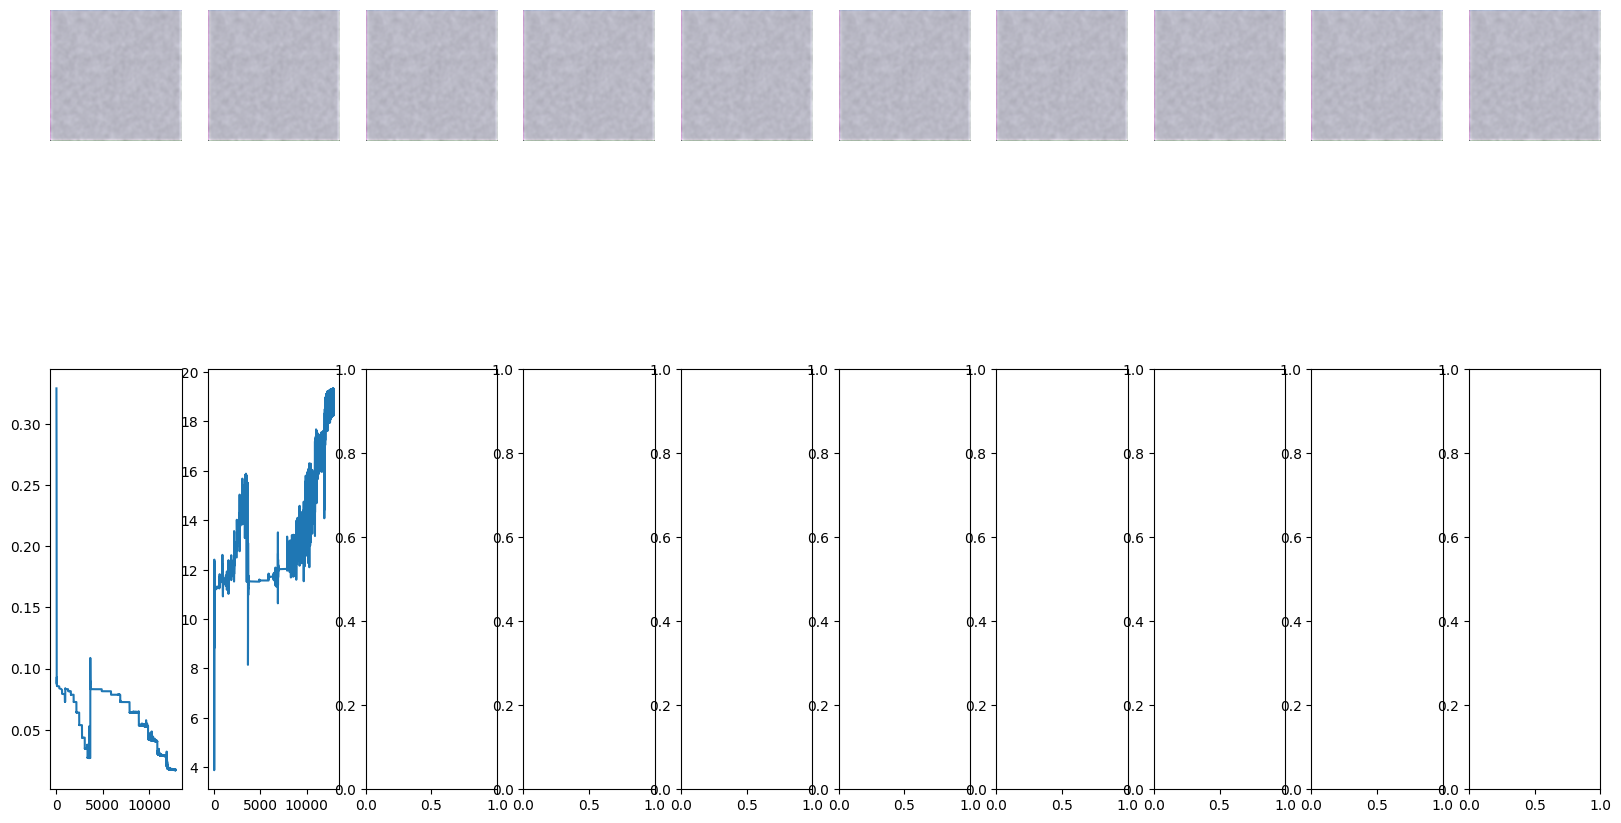

In [78]:
fig1, axis1 = plt.subplots(2, 10, figsize=(20,12))


for i in range(10):
    axis1[0, i].set_axis_off()
    axis1[0, i].imshow(img_array)
    
axis1[1, 0].plot(train_loss)
axis1[1, 1].plot(psnr_list)